In [ ]:
arn:aws:s3:::project1-training

## Prequisites 

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt 
salary_df = pd.read_csv('salary.csv')
X= salary_df[['YearsExperience']] 
y = salary_df[['Salary']] 
X= np.array(X).astype('float32')
y= np.array(y).astype('float32')
from sklearn.model_selection import train_test_split 
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.25) # 20% of data allocated for testing, 80% training

# Salary prediction using SageMaker and Boto3

In [34]:
import sagemaker
import boto3

# define sagemaker session 
sagemaker_sess = sagemaker.Session()

# define s3 bucket 
bucket = 'salaryprediction'

#define a prefix (subfolder in the bucket)
prefix = 'linear_learner'

#get IAM role 
role = sagemaker.get_execution_role()

In [35]:
X_train.shape

(26, 1)

In [36]:
y_train = y_train[:,0] #transforming to a vector format
y_train.shape

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

#### 1. Numpy array --> RecordIO format

In [37]:
import io
import sagemaker.amazon.common as smac #helps us make the conversion below 
# convert a numpy array format to a RecordIO format
buf= io.BytesIO() 
smac.write_numpy_to_dense_tensor(buf, X_train, y_train)
buf.seek(0) 
# the data is in "buf" 

0

#### 2. import data to S3

In [38]:
import os 
key= 'linear-train-data' #name of the file

boto3.resource('s3').Bucket(bucket).Object(os.path.join(prefix,'train',key)).upload_fileobj(buf)

s3_train_data ='s3://{}/{}/train/{}'.format(bucket, prefix, key)
print ('Upload successful. Training data location: {}'.format(s3_train_data))

Upload successful. Training data location: s3://salaryprediction/linear_learner/train/linear-train-data


#### 3. specify outfut location in S3

In [39]:
#specifying output location
output_location= 's3://{}/{}/output'.format(bucket, prefix)

#### 4. get algorithm container image (algorithm to be used: Linear Learner by SageMaker)

In [40]:
from sagemaker.amazon.amazon_estimator import image_uris

container = image_uris.retrieve('linear-learner',boto3.Session().region_name)

INFO:sagemaker.image_uris:Same images used for training and inference. Defaulting to image scope: inference.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: 1.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.


#### 5. Pass information to algorithm container 

In [43]:
linear = sagemaker.estimator.Estimator(container, role,
                                       instance_count= 1,
                                       instance_type='ml.c4.xlarge',
                                       output_path = output_location,
                                       sagemaker_session= sagemaker_sess)
linear.set_hyperparameters(feature_dim = 1, 
                           predictor_type= 'regressor',
                           mini_batch_size = 5, 
                           epochs = 50,
                           num_models = 32,
                           loss = 'absolute_loss' ) 

#pass training data from S3 
linear.fit({'train': s3_train_data})

INFO:sagemaker:Creating training-job with name: linear-learner-2023-04-25-12-06-22-558


2023-04-25 12:06:23 Starting - Starting the training job...
2023-04-25 12:06:47 Starting - Preparing the instances for training......
2023-04-25 12:07:34 Downloading - Downloading input data......
2023-04-25 12:08:39 Training - Downloading the training image...
2023-04-25 12:09:20 Training - Training image download completed. Training in progress.Docker entrypoint called with argument(s): train
Running default environment configuration script
[04/25/2023 12:09:24 INFO 139915425793856] Reading default configuration from /opt/amazon/lib/python3.7/site-packages/algorithm/resources/default-input.json: {'mini_batch_size': '1000', 'epochs': '15', 'feature_dim': 'auto', 'use_bias': 'true', 'binary_classifier_model_selection_criteria': 'accuracy', 'f_beta': '1.0', 'target_recall': '0.8', 'target_precision': '0.8', 'num_models': 'auto', 'num_calibration_samples': '10000000', 'init_method': 'uniform', 'init_scale': '0.07', 'init_sigma': '0.01', 'init_bias': '0.0', 'optimizer': 'auto', 'loss': 'a

#### for optimized price, use spot instances instead! 

#### 7. Deploy model 

In [47]:
linear_regressor= linear.deploy(initial_instance_count = 1, instance_type = 'ml.c4.4xlarge')

INFO:sagemaker:Creating model with name: linear-learner-2023-04-25-12-21-39-780
INFO:sagemaker:Creating endpoint-config with name linear-learner-2023-04-25-12-21-39-780
INFO:sagemaker:Creating endpoint with name linear-learner-2023-04-25-12-21-39-780


------!

#### 8. Pass data in text/csv format

In [55]:
linear_regressor.serializer = sagemaker.serializers.CSVSerializer() 
linear_regressor.deserializer = sagemaker.deserializers.JSONDeserializer()

#### 9. Predicting on test data 

In [56]:
result = linear_regressor.predict(X_test)

In [57]:
result #in JSON format

{'predictions': [{'score': 102751.8203125},
  {'score': 40346.71875},
  {'score': 54491.875},
  {'score': 71965.3046875},
  {'score': 93599.0703125},
  {'score': 60316.3515625},
  {'score': 130210.0703125},
  {'score': 86942.53125},
  {'score': 51995.671875}]}

In [59]:
# transform JSON --> numpy array
predictions = np.array([r['score'] for r in result['predictions']])
predictions

array([102751.8203125,  40346.71875  ,  54491.875    ,  71965.3046875,
        93599.0703125,  60316.3515625, 130210.0703125,  86942.53125  ,
        51995.671875 ])

#### 10. Visualize test results

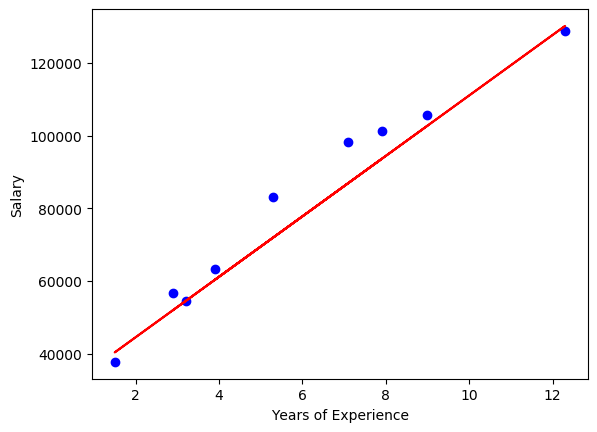

In [60]:
plt.scatter(X_test,y_test, color='blue')
plt.plot(X_test, predictions, color='red')
plt.ylabel('Salary')
plt.xlabel('Years of Experience')
plt.show()

#### 11. Delete the endpoint 

In [62]:
linear_regressor.delete_endpoint()

INFO:sagemaker:Deleting endpoint configuration with name: linear-learner-2023-04-25-12-21-39-780
INFO:sagemaker:Deleting endpoint with name: linear-learner-2023-04-25-12-21-39-780
